Total distance = 1.80 km

Vehicle 1 Route:
Node	ArrTime	DepTime
8	11:00	11:07
0	11:07	11:14
1	11:15	11:22
2	11:22	11:29
3	11:29	11:29
6	11:29	11:36
7	11:36	11:36
4	11:36	11:43
5	11:43	11:43
11	11:43	11:50
10	11:51	11:51
9	11:51	11:58

Vehicle 2 Route:
Node	ArrTime	DepTime
25	15:00	15:00
24	15:00	15:07
13	15:07	15:07
12	15:07	15:14
18	15:14	15:21
17	15:21	15:28
15	15:28	15:28
14	15:28	15:35
16	15:35	15:42
20	15:42	15:42
19	15:42	15:49
22	15:49	15:49
21	15:49	15:56
23	15:56	16:03

Vehicle 1 Unload flags:
  Node 8: No
  Node 0: No
  Node 1: No
  Node 2: No
  Node 3: No
  Node 6: No
  Node 7: No
  Node 4: No
  Node 5: No
  Node 11: No
  Node 10: No
  Node 9: No
Vehicle 1 manual distance = 1.22 km

Vehicle 2 Unload flags:
  Node 25: No
  Node 24: No
  Node 13: No
  Node 12: No
  Node 18: No
  Node 17: No
  Node 15: No
  Node 14: No
  Node 16: No
  Node 20: No
  Node 19: No
  Node 22: No
  Node 21: No
  Node 23: No
Vehicle 2 manual distance = 0.38 km


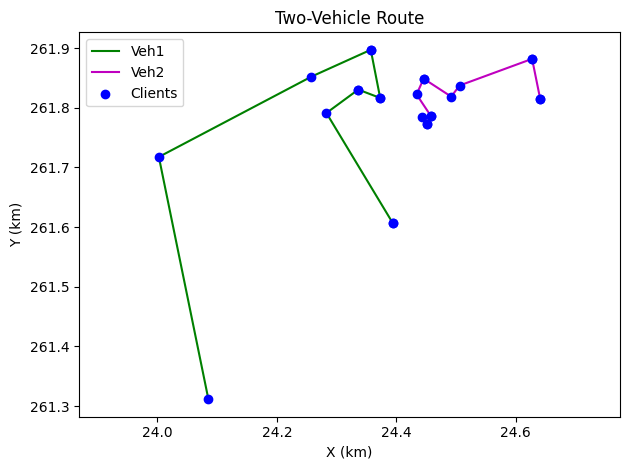

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from ortools.constraint_solver import pywrapcp, routing_enums_pb2

# ──────────────── 1) LOAD & PREP DATA ─────────────────
data0 = pd.read_csv("Data.tsv", delimiter="\t")
num_clients = len(data0)

# Scale lon/lat by 5 and append two “virtual” depots (start, end)
xc = (data0["lon"].to_numpy() * 5).tolist()
yc = (data0["lat"].to_numpy() * 5).tolist()
xDepot = float(np.mean(xc))
yDepot = float(np.mean(yc))
xc += [xDepot, xDepot]
yc += [yDepot, yDepot]

start_depot_idx = num_clients
end_depot_idx   = num_clients + 1
num_nodes       = num_clients + 2

# ───────────── Build distance (m) and travel‐time (s) matrices ──────────
avg_velocity_kmh = 30.0
distance_m = []
time_s     = []

for i in range(num_nodes):
    drow, trow = [], []
    for j in range(num_nodes):
        if i == start_depot_idx:
            d_m = 0
        else:
            dx_m = (xc[i] - xc[j]) * 1000
            dy_m = (yc[i] - yc[j]) * 1000
            d_m  = int(round(math.hypot(dx_m, dy_m)))
        drow.append(d_m)
        trow.append(int(d_m / (avg_velocity_kmh/3.6)))  # km/h→m/s factor 3.6
    distance_m.append(drow)
    time_s.append(trow)

# ─────────── Service times & time windows (s) ─────────────────────────
service_time = [0]*num_nodes
time_windows = [(0, 24*3600)]*num_nodes

def to_sec(hm):
    if pd.isna(hm): return None
    h, m = map(int, str(hm).split(":"))
    return h*3600 + m*60

for i in range(num_clients):
    service_time[i] = int(data0.loc[i, "service_time"])
    ws = to_sec(data0.loc[i, "time_start"])
    we = to_sec(data0.loc[i, "time_end"]) or (26*3600)
    time_windows[i] = (ws, we)

# Force 9:00 departure
time_windows[start_depot_idx] = (9*3600, 9*3600)
service_time[start_depot_idx] = 0
# Free end depot
time_windows[end_depot_idx] = (0, 24*3600)
service_time[end_depot_idx] = 0

# ──────────── 2) SET UP OR-TOOLS ROUTING ──────────────────────────────
num_vehicles = 2
manager = pywrapcp.RoutingIndexManager(
    num_nodes, num_vehicles,
    [start_depot_idx]*num_vehicles,
    [end_depot_idx]*num_vehicles,
)
routing = pywrapcp.RoutingModel(manager)

# a) Distance callback (returns meters)
def dist_cb(from_idx, to_idx):
    i = manager.IndexToNode(from_idx)
    j = manager.IndexToNode(to_idx)
    return distance_m[i][j]

dist_index = routing.RegisterTransitCallback(dist_cb)
routing.SetArcCostEvaluatorOfAllVehicles(dist_index)

# b) Time callback = travel + service (seconds)
def time_cb(from_idx, to_idx):
    i = manager.IndexToNode(from_idx)
    j = manager.IndexToNode(to_idx)
    return time_s[i][j] + service_time[i]

time_index = routing.RegisterTransitCallback(time_cb)

# ──────────── 3) ADD TIME‐WINDOW DIMENSION ─────────────────────────────
routing.AddDimension(
    time_index,
    24*3600,    # allow waiting up to 24h
    24*3600,    # maximum route span
    False,      # don't force start at zero
    "Time"
)
time_dim = routing.GetDimensionOrDie("Time")

# Apply time windows at each vehicle’s start/end
for v in range(num_vehicles):
    time_dim.CumulVar(routing.Start(v)).SetRange(*time_windows[start_depot_idx])
    time_dim.CumulVar(routing.End(v)).SetRange(*time_windows[end_depot_idx])

# Apply time windows for each client
for node in range(num_clients):
    idx = manager.NodeToIndex(node)
    time_dim.CumulVar(idx).SetRange(*time_windows[node])

# ─────────────── 4) SOLVE ──────────────────────────────────────────────
search_params = pywrapcp.DefaultRoutingSearchParameters()
search_params.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
)
search_params.time_limit.seconds = 30

solution = routing.SolveWithParameters(search_params)
if solution is None:
    raise RuntimeError("No solution found.")

# ──────────── 5) PRINT TOTAL COST ────────────────────────────────────
total_m = solution.ObjectiveValue()
print(f"Total distance = {total_m/1000:.2f} km")

# ──────────── 6) EXTRACT & PRINT PER‐VEHICLE ROUTES ───────────────────
all_sequences = []
all_arr = []
all_dep = []

for v in range(num_vehicles):
    idx = routing.Start(v)
    seq, arr, dep = [], {}, {}
    while not routing.IsEnd(idx):
        node = manager.IndexToNode(idx)
        seq.append(node)
        t = solution.Value(time_dim.CumulVar(idx))
        arr[node], dep[node] = t, t + service_time[node]
        idx = solution.Value(routing.NextVar(idx))
    # end depot
    node = manager.IndexToNode(idx)
    seq.append(node)
    t = solution.Value(time_dim.CumulVar(idx))
    arr[node], dep[node] = t, t
    # filter out virtual depots
    clean_seq = [n for n in seq if n not in (start_depot_idx, end_depot_idx)]
    all_sequences.append(clean_seq)
    all_arr .append(arr)
    all_dep .append(dep)

for v, seq in enumerate(all_sequences):
    print(f"\nVehicle {v+1} Route:")
    print("Node\tArrTime\tDepTime")
    for n in seq:
        a, d = all_arr[v][n], all_dep[v][n]
        ah, am = divmod(a//60, 60)
        dh, dm = divmod(d//60, 60)
        print(f"{n}\t{ah:02d}:{am:02d}\t{dh:02d}:{dm:02d}")

# ──────────── 7) APPLY “UNLOAD” LOGIC & OPTIONAL MANUAL CHECK ─────────
for v, seq in enumerate(all_sequences):
    pa = {i: data0.loc[i, "size"] * data0.loc[i, "quantity"] for i in seq}
    Unload = {i: "No" for i in seq}
    running = 0
    for k in range(len(seq)-1):
        running += pa[seq[k]]
        if running + pa[seq[k+1]] >= 1000:
            Unload[seq[k]] = "Yes"
            running = 0
    print(f"\nVehicle {v+1} Unload flags:")
    for n in seq:
        print(f"  Node {n}: {Unload[n]}")

    # Manual distance check
    manual_km = sum(
        math.hypot(xc[seq[i]]-xc[seq[i+1]], yc[seq[i]]-yc[seq[i+1]])
        for i in range(len(seq)-1)
    )
    print(f"Vehicle {v+1} manual distance = {manual_km:.2f} km")

# ──────────── 8) PLOT BOTH ROUTES ────────────────────────────────────
colors = ['g','m']
for v, seq in enumerate(all_sequences):
    for i in range(len(seq)-1):
        i1, i2 = seq[i], seq[i+1]
        plt.plot(
            [xc[i1], xc[i2]], [yc[i1], yc[i2]],
            c=colors[v],
            zorder=0,
            label=f"Veh{v+1}" if i==0 else ""
        )

# plot clients with their own legend entry
plt.scatter(
    xc[:num_clients],
    yc[:num_clients],
    c='b',
    zorder=1,
    label='Clients'
)

plt.legend()
plt.title("Two-Vehicle Route")
plt.xlabel("X (km)")
plt.ylabel("Y (km)")
plt.axis("equal")
plt.tight_layout()
plt.show()


Vehicle #1 route:
Node	ArrTime	DepTime
193	09:00	09:12
150	09:19	09:25
44	09:26	09:39
180	10:00	10:14
103	10:23	10:37
178	10:52	11:02
24	11:17	11:26
82	11:32	11:41
131	11:53	12:05
5	12:11	12:25
151	13:00	13:08
109	13:12	13:25
188	14:00	14:13
30	14:16	14:29
60	14:36	14:44
12	14:50	15:00
147	15:13	15:25
66	15:30	15:36
129	15:38	15:47
113	15:55	16:08

Vehicle #2 route:
Node	ArrTime	DepTime
62	08:00	08:09
171	10:00	10:08
87	10:20	10:27
110	10:37	10:48
9	10:50	11:05

Vehicle #3 route:
Node	ArrTime	DepTime
51	08:00	08:09
124	12:00	12:13
97	13:00	13:11
98	13:15	13:25
74	14:00	14:12
135	14:20	14:35
27	14:41	14:56
152	15:05	15:15
107	15:31	15:38
33	15:49	16:01
46	16:03	16:17
148	16:22	16:34

Vehicle #4 route:
Node	ArrTime	DepTime
32	09:00	09:14
94	10:00	10:14
126	10:19	10:31
170	10:36	10:50
14	12:00	12:05
125	12:13	12:20
143	12:30	12:41
153	12:43	12:58

Vehicle #5 route:
Node	ArrTime	DepTime
4	09:00	09:11
8	09:22	09:30
58	09:36	09:46
38	10:00	10:07
162	10:17	10:26
191	10:27	10:37
67	10:44	10:5

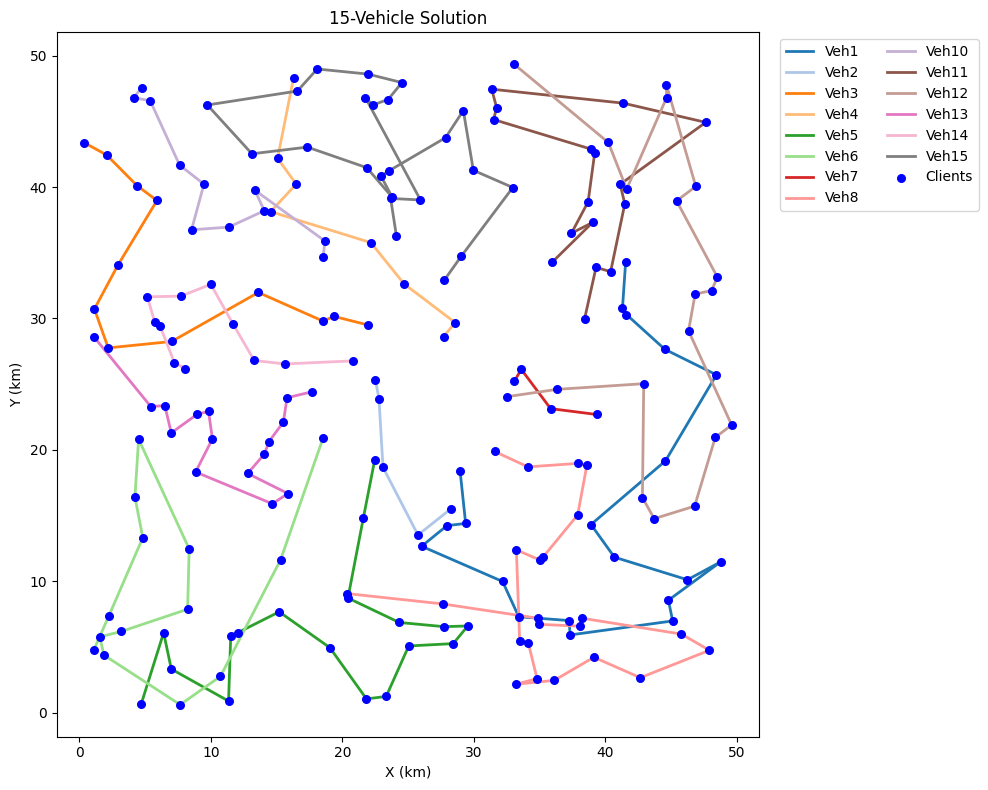

In [7]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from ortools.constraint_solver import pywrapcp, routing_enums_pb2

# ──────────────── 1) LOAD & PREP DATA ─────────────────
data0 = pd.read_csv("Data_200.tsv", delimiter="\t")
num_clients = len(data0)

# Scale lon/lat by 5 and append two “virtual” depots (start, end)
xc = (data0["lon"].to_numpy() * 5).tolist()
yc = (data0["lat"].to_numpy() * 5).tolist()
xDepot = float(np.mean(xc))
yDepot = float(np.mean(yc))
xc += [xDepot, xDepot]
yc += [yDepot, yDepot]

start_depot_idx = num_clients
end_depot_idx   = num_clients + 1
num_nodes       = num_clients + 2

# Build distance (km) and travel-time (s) matrices
avg_velocity_kmh = 30.0
distance_matrix = []
time_matrix     = []
for i in range(num_nodes):
    drow, trow = [], []
    for j in range(num_nodes):
        if i == start_depot_idx:
            d = 0.0
        else:
            dx = xc[i] - xc[j]
            dy = yc[i] - yc[j]
            d  = math.hypot(dx, dy)
        drow.append(int(d))
        trow.append(int(d / (avg_velocity_kmh/3600.0)))
    distance_matrix.append(drow)
    time_matrix.append(trow)

# Service times & time windows (in seconds)
service_time = [0]*num_nodes
time_windows = [(0, 24*3600)]*num_nodes

def to_sec(hm):
    if pd.isna(hm):
        return None
    h, m = map(int, str(hm).split(":"))
    return h*3600 + m*60

for i in range(num_clients):
    service_time[i] = int(data0.loc[i, "service_time"])
    ws = to_sec(data0.loc[i, "time_start"])
    we = to_sec(data0.loc[i, "time_end"]) or (26*3600)
    time_windows[i] = (ws, we)

# Enforce departure at 9 AM from each vehicle’s start depot
time_windows[start_depot_idx] = (9*3600, 9*3600)
service_time[start_depot_idx] = 0

# Allow any end time
time_windows[end_depot_idx] = (0, 24*3600)
service_time[end_depot_idx] = 0

# ──────────── 2) SET UP THE ROUTER ───────────────────────
num_vehicles = 15
manager = pywrapcp.RoutingIndexManager(
    num_nodes,
    num_vehicles,
    [start_depot_idx]*num_vehicles,
    [end_depot_idx]*num_vehicles
)
routing = pywrapcp.RoutingModel(manager)

# a) Distance callback
def dist_cb(from_idx, to_idx):
    i = manager.IndexToNode(from_idx)
    j = manager.IndexToNode(to_idx)
    return distance_matrix[i][j]
dist_idx = routing.RegisterTransitCallback(dist_cb)
routing.SetArcCostEvaluatorOfAllVehicles(dist_idx)

# b) Time callback = travel + service
def time_cb(from_idx, to_idx):
    i = manager.IndexToNode(from_idx)
    j = manager.IndexToNode(to_idx)
    return time_matrix[i][j] + service_time[i]
time_idx = routing.RegisterTransitCallback(time_cb)

# ──────────── 3) ADD TIME-WINDOW DIMENSION ───────────────
routing.AddDimension(
    time_idx,
    24*3600,   # slack max (waiting)
    24*3600,   # route max span
    False,     # do not force start at zero
    "Time"
)
time_dim = routing.GetDimensionOrDie("Time")

# Apply windows for depots and clients
time_dim.CumulVar(routing.Start(0)).SetRange(*time_windows[start_depot_idx])
time_dim.CumulVar(routing.End(0)).SetRange(*time_windows[end_depot_idx])
for node in range(num_clients):
    idx = manager.NodeToIndex(node)
    time_dim.CumulVar(idx).SetRange(*time_windows[node])

# ──────────────── 4) SOLVE ───────────────────────────────
search_params = pywrapcp.DefaultRoutingSearchParameters()
search_params.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
)
search_params.time_limit.seconds = 30

solution = routing.SolveWithParameters(search_params)
if solution is None:
    raise RuntimeError("No solution found even with 2 vehicles and relaxed windows.")

# ──────────────── 5) EXTRACT & PRINT PER-VEHICLE ROUTES ──
all_sequences = []
all_arr = []
all_dep = []

for vid in range(num_vehicles):
    idx = routing.Start(vid)
    seq = []
    arr, dep = {}, {}
    while not routing.IsEnd(idx):
        node = manager.IndexToNode(idx)
        seq.append(node)
        t = solution.Value(time_dim.CumulVar(idx))
        arr[node], dep[node] = t, t + service_time[node]
        idx = solution.Value(routing.NextVar(idx))
    # end depot
    node = manager.IndexToNode(idx)
    seq.append(node)
    t = solution.Value(time_dim.CumulVar(idx))
    arr[node], dep[node] = t, t
    # filter out virtual depots
    clean_seq = [n for n in seq if n not in (start_depot_idx, end_depot_idx)]
    all_sequences.append(clean_seq)
    all_arr .append(arr)
    all_dep .append(dep)

# Print
for vid, seq in enumerate(all_sequences):
    print(f"\nVehicle #{vid+1} route:")
    print("Node\tArrTime\tDepTime")
    for n in seq:
        a = all_arr[vid][n]
        d = all_dep[vid][n]
        ah, am = divmod(a//60, 60)
        dh, dm = divmod(d//60, 60)
        print(f"{n}\t{ah:02d}:{am:02d}\t{dh:02d}:{dm:02d}")

# ──────────────── 6) APPLY “UNLOAD” LOGIC ───────────────
for vid, seq in enumerate(all_sequences):
    PickAmount = {
        i: data0.loc[i, "size"]*data0.loc[i, "quantity"]
        for i in seq
    }
    Unload = {i: "No" for i in seq}
    running = 0
    for k in range(len(seq)-1):
        running += PickAmount[seq[k]]
        if running + PickAmount[seq[k+1]] >= 1000:
            Unload[seq[k]] = "Yes"
            running = 0
    print(f"\nVehicle #{vid+1} Unload flags:")
    for n in seq:
        print(f"  Node {n}: {Unload[n]}")

# ──────────────── 7) PLOT THE 20 ROUTES ────────────────────────────────

# grab 20 distinct colors
cmap   = plt.get_cmap('tab20')
colors = [cmap(i) for i in range(num_vehicles)]

plt.figure(figsize=(10,8))
labels_shown = [False]*num_vehicles

for vid, seq in enumerate(all_sequences):
    for seg in range(len(seq)-1):
        i1, i2 = seq[seg], seq[seg+1]
        plt.plot(
            [xc[i1], xc[i2]],
            [yc[i1], yc[i2]],
            color=colors[vid],
            linewidth=2,
            zorder=0,
            label=(f"Veh{vid+1}" if not labels_shown[vid] else None)
        )
        labels_shown[vid] = True

# plot clients in blue
plt.scatter(
    xc[:num_clients],
    yc[:num_clients],
    c='b', s=30,
    zorder=1,
    label='Clients'
)

plt.title("15-Vehicle Solution")
plt.xlabel("X (km)")
plt.ylabel("Y (km)")
plt.axis('equal')
plt.legend(ncol=2, bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout()
plt.show()


In [8]:
# after you have `solution`
total_km = 0
for vid in range(num_vehicles):
    index = routing.Start(vid)
    while not routing.IsEnd(index):
        next_index = solution.Value(routing.NextVar(index))
        i = manager.IndexToNode(index)
        j = manager.IndexToNode(next_index)
        total_km += distance_matrix[i][j]
        index = next_index

print(f"\nTotal distance of all routes: {total_km} km")



Total distance of all routes: 680 km


I0000 00:00:1754925836.912694  860666 search.cc:285] Start search (memory used = 129.38 MB)
I0000 00:00:1754925836.912899  860666 search.cc:285] Root node processed (time = 0 ms, constraints = 1370, memory used = 129.41 MB)
I0000 00:00:1754925836.940130  860666 search.cc:285] Solution #0 (1117, time = 27 ms, branches = 34, failures = 1, depth = 33, memory used = 131.31 MB, limit = 0%)
I0000 00:00:1754925836.941321  860666 search.cc:285] Solution #1 (1116, maximum = 1117, time = 28 ms, branches = 39, failures = 4, depth = 33, Relocate<1>, neighbors = 1235, filtered neighbors = 1, accepted neighbors = 1, memory used = 131.45 MB, limit = 0%)
I0000 00:00:1754925836.941752  860666 search.cc:285] Solution #2 (1112, maximum = 1117, time = 29 ms, branches = 45, failures = 7, depth = 33, Relocate<1>, neighbors = 1236, filtered neighbors = 2, accepted neighbors = 2, memory used = 131.80 MB, limit = 0%)
I0000 00:00:1754925836.942354  860666 search.cc:285] Solution #3 (1109, maximum = 1117, time =


Vehicle #1 route:
Node	ArrTime	DepTime
4	09:00	09:11
38	10:00	10:07
162	10:17	10:26
174	10:34	10:47
8	10:53	11:00
17	11:07	11:19
175	11:22	11:37
68	13:00	13:14
149	13:16	13:27
163	14:00	14:07
58	14:17	14:27
194	14:33	14:40
70	14:48	14:56
191	15:03	15:14
67	15:21	15:29
168	15:48	16:02
172	16:09	16:18
75	16:22	16:34
47	16:36	16:46
199	16:50	16:58
165	17:04	17:09

Vehicle #2 route:
Node	ArrTime	DepTime
35	08:00	08:08
170	08:19	08:33
189	08:42	08:56
94	10:00	10:14
133	10:19	10:32
32	10:43	10:57
146	12:00	12:13
96	12:18	12:25
1	12:33	12:43
141	12:48	12:54
34	12:58	13:09
176	13:13	13:27
92	13:29	13:38
40	13:48	13:58
61	14:01	14:15
56	14:17	14:24
10	14:39	14:50

Vehicle #3 route:
Node	ArrTime	DepTime
65	08:00	08:05
171	10:00	10:08
62	10:14	10:24
118	11:00	11:09
87	11:17	11:25
106	14:00	14:07

Vehicle #4 route:
Node	ArrTime	DepTime
114	09:00	09:14
111	09:19	09:28
195	09:32	09:43
36	10:00	10:05
154	11:00	11:07
88	11:15	11:21
127	11:22	11:28
152	11:31	11:41
192	11:44	11:59
59	12:00	12:13
128	12

I0000 00:00:1754926016.871911  860666 search.cc:285] Solution #6931 (626, minimum = 609, maximum = 1117, time = 179959 ms, branches = 46149, failures = 24196, depth = 33, Relocate<1>, neighbors = 176619390, filtered neighbors = 6931, accepted neighbors = 6931, memory used = 139.20 MB, limit = 99%)
I0000 00:00:1754926016.880095  860666 search.cc:285] Solution #6932 (626, minimum = 609, maximum = 1117, time = 179967 ms, branches = 46155, failures = 24199, depth = 33, Relocate<1>, neighbors = 176633959, filtered neighbors = 6932, accepted neighbors = 6932, memory used = 139.20 MB, limit = 99%)
I0000 00:00:1754926016.911796  860666 search.cc:285] Finished search tree (time = 179999 ms, branches = 46158, failures = 24228, neighbors = 176684393, filtered neighbors = 6932, accepted neigbors = 6932, memory used = 139.20 MB)
I0000 00:00:1754926016.911904  860666 search.cc:285] End search (time = 179999 ms, branches = 46158, failures = 24228, memory used = 139.20 MB, speed = 256 branches/s)


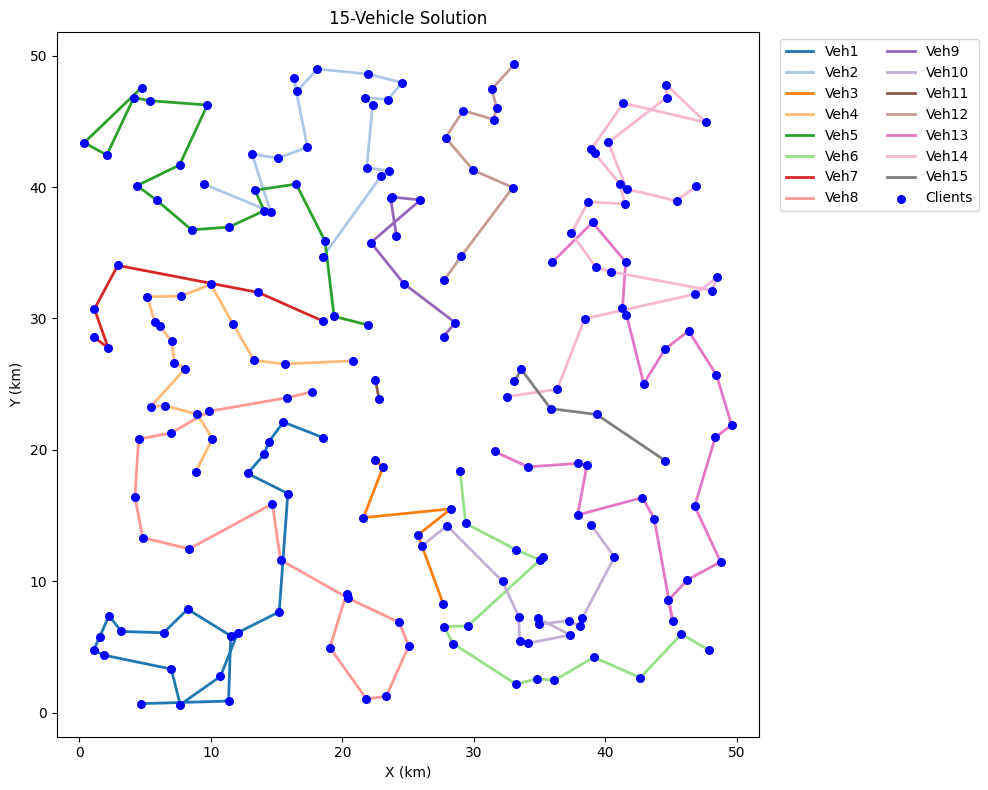

In [12]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from ortools.constraint_solver import pywrapcp, routing_enums_pb2

# ──────────────── 1) LOAD & PREP DATA ─────────────────
data0 = pd.read_csv("Data_200.tsv", delimiter="\t")
num_clients = len(data0)

# Scale lon/lat by 5 and append two “virtual” depots (start, end)
xc = (data0["lon"].to_numpy() * 5).tolist()
yc = (data0["lat"].to_numpy() * 5).tolist()
xDepot = float(np.mean(xc))
yDepot = float(np.mean(yc))
xc += [xDepot, xDepot]
yc += [yDepot, yDepot]

start_depot_idx = num_clients
end_depot_idx   = num_clients + 1
num_nodes       = num_clients + 2

# Build distance (km) and travel-time (s) matrices
avg_velocity_kmh = 30.0
distance_matrix = []
time_matrix     = []
for i in range(num_nodes):
    drow, trow = [], []
    for j in range(num_nodes):
        if i == start_depot_idx:
            d = 0.0
        else:
            dx = xc[i] - xc[j]
            dy = yc[i] - yc[j]
            d  = math.hypot(dx, dy)
        drow.append(int(d))
        trow.append(int(d / (avg_velocity_kmh/3600.0)))
    distance_matrix.append(drow)
    time_matrix.append(trow)

# Service times & time windows (in seconds)
service_time = [0]*num_nodes
time_windows = [(0, 24*3600)]*num_nodes

def to_sec(hm):
    if pd.isna(hm):
        return None
    h, m = map(int, str(hm).split(":"))
    return h*3600 + m*60

for i in range(num_clients):
    service_time[i] = int(data0.loc[i, "service_time"])
    ws = to_sec(data0.loc[i, "time_start"])
    we = to_sec(data0.loc[i, "time_end"]) or (26*3600)
    time_windows[i] = (ws, we)

# Enforce departure at 9 AM from each vehicle’s start depot
time_windows[start_depot_idx] = (9*3600, 9*3600)
service_time[start_depot_idx] = 0

# Allow any end time
time_windows[end_depot_idx] = (0, 24*3600)
service_time[end_depot_idx] = 0

# ──────────── 2) SET UP THE ROUTER ───────────────────────
num_vehicles = 15
manager = pywrapcp.RoutingIndexManager(
    num_nodes,
    num_vehicles,
    [start_depot_idx]*num_vehicles,
    [end_depot_idx]*num_vehicles
)
routing = pywrapcp.RoutingModel(manager)

# a) Distance callback
def dist_cb(from_idx, to_idx):
    i = manager.IndexToNode(from_idx)
    j = manager.IndexToNode(to_idx)
    return distance_matrix[i][j]
dist_idx = routing.RegisterTransitCallback(dist_cb)
routing.SetArcCostEvaluatorOfAllVehicles(dist_idx)

# b) Time callback = travel + service
def time_cb(from_idx, to_idx):
    i = manager.IndexToNode(from_idx)
    j = manager.IndexToNode(to_idx)
    return time_matrix[i][j] + service_time[i]
time_idx = routing.RegisterTransitCallback(time_cb)

# ──────────── 3) ADD TIME-WINDOW DIMENSION ───────────────
routing.AddDimension(
    time_idx,
    24*3600,   # slack max (waiting)
    24*3600,   # route max span
    False,     # do not force start at zero
    "Time"
)
time_dim = routing.GetDimensionOrDie("Time")

# Apply windows for depots and clients
time_dim.CumulVar(routing.Start(0)).SetRange(*time_windows[start_depot_idx])
time_dim.CumulVar(routing.End(0)).SetRange(*time_windows[end_depot_idx])
for node in range(num_clients):
    idx = manager.NodeToIndex(node)
    time_dim.CumulVar(idx).SetRange(*time_windows[node])

# ───── 4A) Record cost vs time during search ─────
best_curve_time_s = []
best_curve_cost   = []

solver = routing.solver()
def at_solution_cb():
    t_s = solver.WallTime() / 1000.0           # ms → s
    obj = routing.CostVar().Value()            # current best objective
    best_curve_time_s.append(t_s)
    best_curve_cost.append(obj)

routing.AddAtSolutionCallback(at_solution_cb)

# Optional: log improvements to stdout
#search_params.log_search = True

# ──────────────── 4) SOLVE ───────────────────────────────
#search_params = pywrapcp.DefaultRoutingSearchParameters()
#search_params.first_solution_strategy = (
#    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
#)
#search_params.time_limit.seconds = 20



search_params = pywrapcp.DefaultRoutingSearchParameters()
search_params.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PARALLEL_CHEAPEST_INSERTION
search_params.local_search_metaheuristic = routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
search_params.guided_local_search_lambda_coefficient = 0.1  # tune: 0.05–0.2 often good
search_params.time_limit.seconds = 180  # give it time; 20s is tight for 500 nodes
search_params.log_search = True

solution = routing.SolveWithParameters(search_params)
if solution is None:
    raise RuntimeError("No solution found even with 2 vehicles and relaxed windows.")


# ──────────────── 5) EXTRACT & PRINT PER-VEHICLE ROUTES ──
all_sequences = []
all_arr = []
all_dep = []

for vid in range(num_vehicles):
    idx = routing.Start(vid)
    seq = []
    arr, dep = {}, {}
    while not routing.IsEnd(idx):
        node = manager.IndexToNode(idx)
        seq.append(node)
        t = solution.Value(time_dim.CumulVar(idx))
        arr[node], dep[node] = t, t + service_time[node]
        idx = solution.Value(routing.NextVar(idx))
    # end depot
    node = manager.IndexToNode(idx)
    seq.append(node)
    t = solution.Value(time_dim.CumulVar(idx))
    arr[node], dep[node] = t, t
    # filter out virtual depots
    clean_seq = [n for n in seq if n not in (start_depot_idx, end_depot_idx)]
    all_sequences.append(clean_seq)
    all_arr .append(arr)
    all_dep .append(dep)

# Print
for vid, seq in enumerate(all_sequences):
    print(f"\nVehicle #{vid+1} route:")
    print("Node\tArrTime\tDepTime")
    for n in seq:
        a = all_arr[vid][n]
        d = all_dep[vid][n]
        ah, am = divmod(a//60, 60)
        dh, dm = divmod(d//60, 60)
        print(f"{n}\t{ah:02d}:{am:02d}\t{dh:02d}:{dm:02d}")

# ──────────────── 6) APPLY “UNLOAD” LOGIC ───────────────
for vid, seq in enumerate(all_sequences):
    PickAmount = {
        i: data0.loc[i, "size"]*data0.loc[i, "quantity"]
        for i in seq
    }
    Unload = {i: "No" for i in seq}
    running = 0
    for k in range(len(seq)-1):
        running += PickAmount[seq[k]]
        if running + PickAmount[seq[k+1]] >= 1000:
            Unload[seq[k]] = "Yes"
            running = 0
    print(f"\nVehicle #{vid+1} Unload flags:")
    for n in seq:
        print(f"  Node {n}: {Unload[n]}")

# ──────────────── 7) PLOT THE 20 ROUTES ────────────────────────────────

# grab 20 distinct colors
cmap   = plt.get_cmap('tab20')
colors = [cmap(i) for i in range(num_vehicles)]

plt.figure(figsize=(10,8))
labels_shown = [False]*num_vehicles

for vid, seq in enumerate(all_sequences):
    for seg in range(len(seq)-1):
        i1, i2 = seq[seg], seq[seg+1]
        plt.plot(
            [xc[i1], xc[i2]],
            [yc[i1], yc[i2]],
            color=colors[vid],
            linewidth=2,
            zorder=0,
            label=(f"Veh{vid+1}" if not labels_shown[vid] else None)
        )
        labels_shown[vid] = True

# plot clients in blue
plt.scatter(
    xc[:num_clients],
    yc[:num_clients],
    c='b', s=30,
    zorder=1,
    label='Clients'
)

plt.title("15-Vehicle Solution")
plt.xlabel("X (km)")
plt.ylabel("Y (km)")
plt.axis('equal')
plt.legend(ncol=2, bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout()
plt.show()



Time(s), Objective
0.033, 1117
0.035, 1116
0.035, 1112
0.036, 1109
0.036, 1107
0.036, 1102
0.037, 1101
0.038, 1100
0.038, 1095
0.038, 1094
0.039, 1092
0.041, 1091
0.041, 1086
0.042, 1084
0.042, 1082
0.042, 1081
0.043, 1080
0.043, 1072
0.044, 1069
0.047, 1064
0.048, 1062
0.048, 1060
0.049, 1059
0.049, 1057
0.051, 1054
0.051, 1050
0.052, 1049
0.053, 1046
0.054, 1042
0.054, 1037
0.054, 1030
0.056, 1028
0.056, 1025
0.057, 1021
0.057, 1019
0.057, 1016
0.059, 1012
0.059, 1007
0.060, 1006
0.060, 1005
0.061, 999
0.061, 997
0.062, 994
0.063, 990
0.063, 988
0.064, 986
0.065, 984
0.066, 983
0.066, 979
0.067, 973
0.067, 972
0.068, 970
0.068, 969
0.068, 968
0.069, 967
0.071, 963
0.072, 961
0.073, 956
0.073, 946
0.074, 941
0.075, 936
0.077, 929
0.078, 928
0.078, 927
0.078, 926
0.079, 925
0.079, 922
0.081, 918
0.082, 915
0.083, 913
0.083, 912
0.084, 900
0.085, 895
0.085, 894
0.085, 891
0.087, 889
0.088, 888
0.089, 886
0.090, 885
0.090, 879
0.091, 878
0.092, 877
0.095, 871
0.096, 870
0.098, 868
0.100

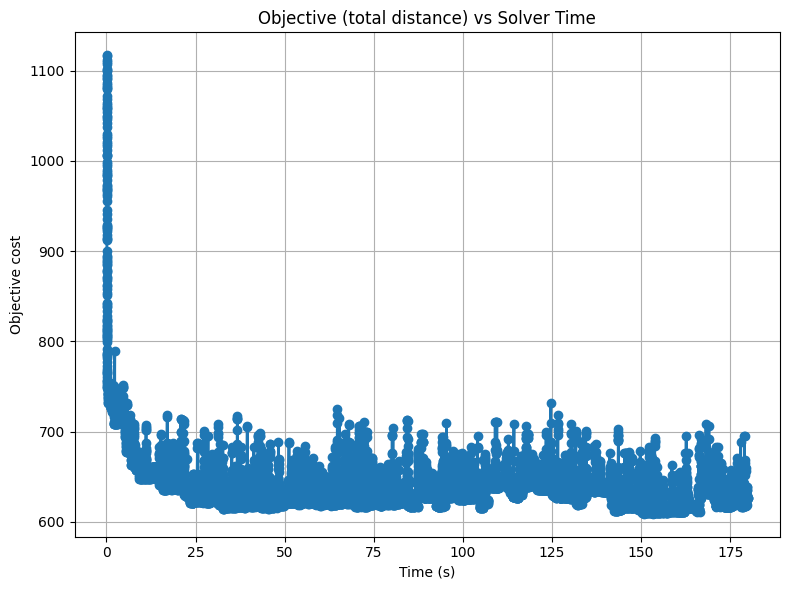

In [13]:
# ───── Plot cost vs time ─────
if best_curve_time_s:
    print("\nTime(s), Objective")
    for t, c in zip(best_curve_time_s, best_curve_cost):
        print(f"{t:.3f}, {c}")

    plt.figure(figsize=(8, 6))
    plt.plot(best_curve_time_s, best_curve_cost, marker='o', linewidth=2)
    plt.title("Objective (total distance) vs Solver Time")
    plt.xlabel("Time (s)")
    plt.ylabel("Objective cost")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No intermediate solutions were recorded.")


In [14]:
# after you have `solution`
total_km = 0
for vid in range(num_vehicles):
    index = routing.Start(vid)
    while not routing.IsEnd(index):
        next_index = solution.Value(routing.NextVar(index))
        i = manager.IndexToNode(index)
        j = manager.IndexToNode(next_index)
        total_km += distance_matrix[i][j]
        index = next_index

print(f"\nTotal distance of all routes: {total_km} km")



Total distance of all routes: 609 km


In [15]:
# ───── Print objective (cost) and solver time ─────
solver = routing.solver()
final_time_s = solver.WallTime() / 1000.0    # ms → s
final_obj    = solution.ObjectiveValue()     # same as routing.CostVar().Value()

print("\n=== OPTIMIZATION SUMMARY ===")
print(f"Final objective (sum of arc distances): {final_obj}")
print(f"Solver wall time (s): {final_time_s:.3f}")



=== OPTIMIZATION SUMMARY ===
Final objective (sum of arc distances): 609
Solver wall time (s): 180.185


500

=== OPTIMIZATION SUMMARY ===
Final objective (sum of arc distances): 737
Solver wall time (s): 236.097




200

=== OPTIMIZATION SUMMARY ===
Final objective (sum of arc distances): 609
Solver wall time (s): 180.185

